# Advanced RAG with Gemma, Weaviate, and LlamaIndex

This Notebook shows you the basic steps to build an advanced Retrieval-Augmented Generation (RAG) pipeline using the following building blocks:

* Google's open source large language model (LLM), [Gemma](https://www.kaggle.com/models/google/gemma) model via Kaggle models.
* [Weaviate](weaviate.io)'s open source vector datbase for external context.
* [LlamaIndex](https://www.llamaindex.ai/) for orchestration.

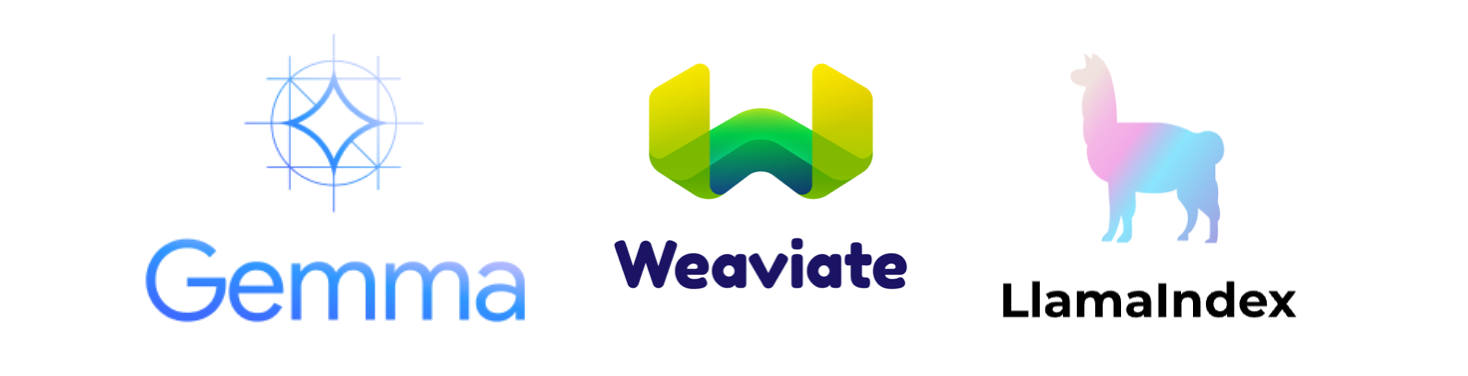

For a tutorial on building a **naive RAG pipeline**, you can check out my previous Notebook [RAG with Gemma on HF 🤗 and Weaviate in DSPy](https://www.kaggle.com/code/iamleonie/rag-with-gemma-on-hf-and-weaviate-in-dspy).

In [1]:
import warnings
warnings.filterwarnings('ignore')

# What is Advanced RAG?

Advanced RAG is a RAG paradigm, which comprises of a set of techniques targeted at addressing known limitations of naive RAG.
Below, you can see a naive RAG workflow on the left-hand side. 
On the right-hand side, you can see how advanced RAG techniques can be categorized into:
* Pre-retrieval
* Retrieval
* Post-retrieval techniques

as discussed in the paper "Retrieval-augmented generation for large language models: A survey" [2].

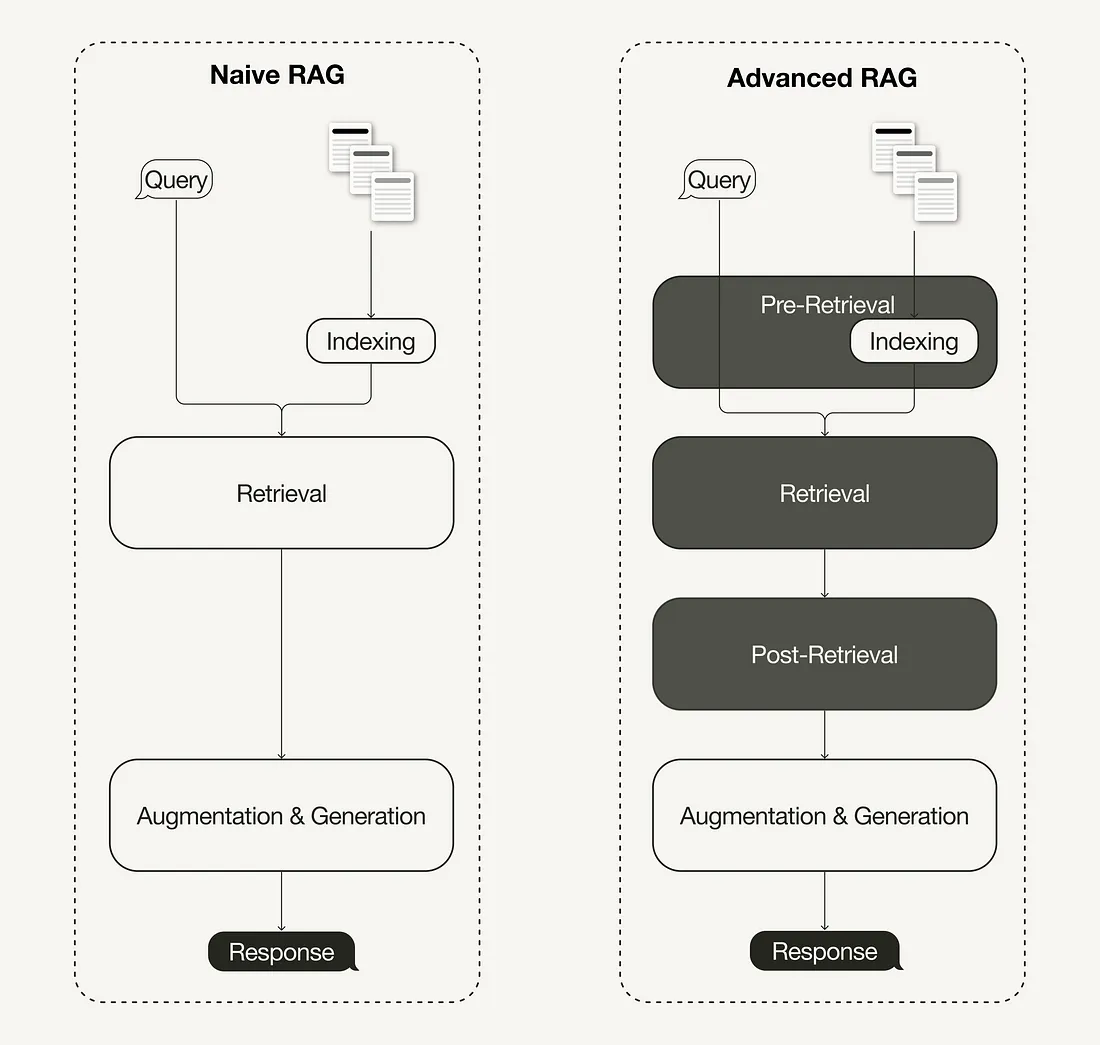

*(Image by the author, [Leonie](https://www.kaggle.com/iamleonie), originally published in [Advanced Retrieval-Augmented Generation: From Theory to LlamaIndex Implementation](https://medium.com/p/4de1464a9930))*

This Notebook shows you a selection of advanced RAG techniques using LlamaIndex. Namely, we are exploring the following techniques:
* Pre-retrieval: [Auto-Retrieval (Metadata filtering)](https://docs.llamaindex.ai/en/stable/examples/vector_stores/chroma_auto_retriever.html)
* Retrieval: [Hybrid Search](https://docs.llamaindex.ai/en/stable/examples/vector_stores/WeaviateIndexDemo-Hybrid.html)
* Post-retrieval techniques: [Reranking](https://docs.llamaindex.ai/en/latest/module_guides/querying/node_postprocessors/node_postprocessors.html#sentencetransformerrerank), [Few-Shot prompt engineering](https://docs.llamaindex.ai/en/stable/examples/prompts/prompts_rag.html#adding-few-shot-examples)

For more ideas on advanced RAG techniques, you can check out my article [Advanced Retrieval-Augmented Generation: From Theory to LlamaIndex Implementation](https://medium.com/p/4de1464a9930), which discusses a variety of advanced RAG techniques and also implements some of them, such as Sentence-window retrieval.

# Prerequisites
First, you will need to install the following packages.

In [2]:
!pip install -q -U keras-nlp
!pip install -q -U keras>3
!pip install -q -U llama_index
!pip install llama-index-embeddings-huggingface
!pip install weaviate-client
!pip install llama-index-vector-stores-weaviate
!pip install torch sentence-transformers

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.1.1 which is incompatible.
tensorflowjs 4.16.0 requires packaging~=23.1, but you have packaging 21.3 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible

# Step 1: Define Gemma as a Custom LLM

As Gemma isn't supported out-of-the-box by LlamaIndex (at the time of writing), we need to define a custom model as shown in the [LlamaIndex Docs: Using a Custom LLM Model - Advanced](https://docs.llamaindex.ai/en/stable/module_guides/models/llms/usage_custom.html#example-using-a-custom-llm-model-advanced).

Note, that you can use Gemma via the HuggingFace integration. However, I want to showcase how to use Gemma through a custom class in case you want to fine-tune Gemma and use the fine-tuned model.

In [3]:
import keras
import keras_nlp
import os

os.environ["KERAS_BACKEND"] = "jax"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma_instruct_2b_en")

2024-03-22 06:30:25.381086: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 06:30:25.381277: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-22 06:30:25.567249: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Attaching 'config.json' from model 'keras/gemma/keras/gemma_instruct_2b_en/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/gemma/keras/gemma_instruct_2b_en/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/gemma/keras/gemma_instruct_2b_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/

For a sanity check that everything works as intended, we will run a `sample_query` with the `keras_nlp` model and with the custom LlamaIndex model and compare the completions.

In [4]:
sample_query = "What is a good backbone for the Kaggle competition with the title 'Feedback Prize - English Language Learning'?"

print(gemma_lm.generate(sample_query, max_length=512))

I0000 00:00:1711089180.182225      18 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-03-22 06:33:00.231247: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


What is a good backbone for the Kaggle competition with the title 'Feedback Prize - English Language Learning'?

Here's what I have so far:

**1. Topic Modeling:**
* Use TF-IDF to identify the most relevant topics in the dataset.
* Choose the top 5 topics that contribute the most to the overall topic distribution.

**2. Feature Engineering:**
* Extract features from the text data, such as:
    * Word count
    * Average sentence length
    * Number of unique words
    * Part-of-speech tags
    * Named entities

**3. Model Selection and Training:**
* Choose a suitable machine learning model for sentiment analysis, such as:
    * Naive Bayes
    * Support Vector Machines (SVM)
    * Random Forest
    * LSTM
* Train the model on the feature data and labeled data (positive and negative examples).

**4. Evaluation and Improvement:**
* Evaluate the model's performance using metrics such as accuracy, precision, and recall.
* Iterate on the model by tuning hyperparameters and trying different 

In [5]:
from typing import Any

from llama_index.core.callbacks import CallbackManager
from llama_index.core.llms import (
    CustomLLM,
    CompletionResponse,
    CompletionResponseGen,
    LLMMetadata,
)
from llama_index.core.llms.callbacks import llm_completion_callback

class Gemma(CustomLLM):
    num_output: int = 512
    model_name: str = "Gemma"
    model: Any = None

    def __init__(self, model, num_output):
        super(Gemma, self).__init__()
        self.model = model
        self.num_output = num_output

    @property
    def metadata(self) -> LLMMetadata:
        """Get LLM metadata."""
        return LLMMetadata(
            num_output=self.num_output,
            model_name=self.model_name,
        )

    @llm_completion_callback()
    def complete(self, prompt: str, **kwargs: Any) -> CompletionResponse:
        return CompletionResponse(text=self.model.generate(prompt, max_length=self.num_output))

    @llm_completion_callback()
    def stream_complete(self, prompt: str, **kwargs: Any) -> CompletionResponseGen:
        response = ""
        for token in self.model.generate(prompt, max_length=self.num_output):
            response += token
            yield CompletionResponse(text=response, delta=token)

Now, let's try it out with the same `sample_query`:

In [6]:
response = Gemma(gemma_lm, 512).complete(sample_query)

print(response.text)

What is a good backbone for the Kaggle competition with the title 'Feedback Prize - English Language Learning'?

Here's what I have so far:

**1. Topic Modeling:**
* Use TF-IDF to identify the most relevant topics in the dataset.
* Choose the top 5 topics that contribute the most to the overall topic distribution.

**2. Feature Engineering:**
* Extract features from the text data, such as:
    * Word count
    * Average sentence length
    * Number of unique words
    * Part-of-speech tags
    * Named entities

**3. Model Selection and Training:**
* Choose a suitable machine learning model for sentiment analysis, such as:
    * Naive Bayes
    * Support Vector Machines (SVM)
    * Random Forest
    * LSTM
* Train the model on the feature data and labeled data (positive and negative examples).

**4. Evaluation and Improvement:**
* Evaluate the model's performance using metrics such as accuracy, precision, and recall.
* Iterate on the model by tuning hyperparameters and trying different 

Our custom LLM `Gemma()` object for the LlamaIndex framework is now able to generate the same completion as the `keras_nlp` object. Great!

You can also use this custom class if you want to **fine-tune** Gemma and continue working with the fine-tuned model.

# Step 2: Define Embedding Model and LLM
Now that you have Gemma ready to go with LlamaIndex, you can define an embedding model and LLM in a global settings object. By doing this, you don't have to specify the models explicitly in the code again.

* Embedding model: used to generate vector embeddings for the document chunks as well as the query.
* LLM: used to generate an answer based on the user query and the relevant context.

In [7]:
from llama_index.core.settings import Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

Settings.llm = Gemma(gemma_lm, 512)
Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

# Step 3: Load data

Next, you will load the data to be stored in the external knowledge source.

In this Notebook, we will use solution writeups from 2023 Kaggle Competition's provided in the [2023 Kaggle AI Report](https://www.kaggle.com/competitions/2023-kaggle-ai-report), which is prepared from the the [Kaggle metadata dataset](https://www.kaggle.com/datasets/kaggle/meta-kaggle), as this will require no data processing, so we can focus on the overall flow of the RAG technique.

In [8]:
import pandas as pd

df = pd.read_csv("/kaggle/input/2023-kaggle-ai-report/kaggle_writeups_20230510.csv")

# Only use the 1% of write ups to save time during development
df = df.sample(frac=0.01, random_state=1)

display(df.head())

,Competition Launch Date,Title of Competition,Competition URL,Date of Writeup,Title of Writeup,Writeup,Writeup URL
2957,08/30/2022 17:23:07,Feedback Prize - English Language Learning,https://www.kaggle.com/c/38321,12/01/2022 10:39:02,47th Place Solution,"<p>First of all, thanks for hosting this compe...",https://www.kaggle.com/c/38321/discussion/369770
110,11/24/2014 20:08:02,Helping Santa's Helpers,https://www.kaggle.com/c/3973,01/08/2015 05:08:44,How I got my run time down from 10 hours to 10...,<p>Earlier in this forum there was a post abou...,https://www.kaggle.com/c/3973/discussion/11452
1787,08/24/2020 20:13:59,Lyft Motion Prediction for Autonomous Vehicles,https://www.kaggle.com/c/19990,12/19/2020 21:42:04,3rd Place Solution: Baseline + Set Transformer,<p>Update: YouTube video about our solution <a...,https://www.kaggle.com/c/19990/discussion/205376
516,01/16/2018 14:00:00,2018 Data Science Bowl,https://www.kaggle.com/c/8089,04/18/2018 13:40:09,My Solution 11th place (LB 0.590),<p>（currently 8th place while leaderboard is b...,https://www.kaggle.com/c/8089/discussion/54838
340,05/16/2017 15:31:40,Instacart Market Basket Analysis,https://www.kaggle.com/c/6644,08/17/2017 15:53:57,54th solution with a nice user_product purchas...,"<p>Hey,</p>\n\n<p>I publish a bit lately my so...",https://www.kaggle.com/c/6644/discussion/38248


Using the `Document` class, you can create documents with metadata. This can be helpful if you want to use metadata filtering later on. (Note, that metadata filtering has to be supported by your vector database.)

In this example, we are adding the title of the competition as metadata.

In [9]:
from llama_index.core import Document

documents = [Document(
    text= row['Writeup'],
    metadata={"competition_title": row['Title of Competition']},
) for _, row in df.iterrows()]


print((documents[0].text))

documents[0]

<p>First of all, thanks for hosting this competition and congratulations to all the participants. This is my first time to get medal in Kaggle, I've  learned a lot from this experience.</p>
<h1>Overview</h1>
<p>My solution is training a lots of models with different parameters(pooling techniques, backbones, max_len, seed) and ensemble them by weighted average. My best CV score is 0.4484.</p>
<h1>Best Model Configuration</h1>
<ul>
<li>Backbone: deberta-v3-base</li>
<li>Pooling: mean</li>
<li>Max_len: 512</li>
<li>Learning rate:<ul>
<li>Encoder: 2e-4 (layer-wise lr decay: 0.25)</li>
<li>Decoder: 1e-3</li></ul></li>
<li>Epoch: 4 (1 for warm up)</li>
<li>Batch size: 8</li>
<li>Fold: 5</li>
<li>Seed: 42</li>
</ul>
<h1>Parameters</h1>
<ul>
<li>Backbone: deberta-v3-base, deberta-v3-large, deberta-v3-small</li>
<li>Pooling: mean, cls, max, weighted layer(use last 4 or 5 layers)</li>
<li>Max_len: 512, 768, 1024, 1536</li>
<li>Seed: 13, 42</li>
<li>Epoch: 3, 4, 5</li>
</ul>
<h1>Ensemble</h1>
<p>

Document(id_='126299da-dd5c-4648-8815-5bbc6ea75713', embedding=None, metadata={'competition_title': 'Feedback Prize - English Language Learning'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='<p>First of all, thanks for hosting this competition and congratulations to all the participants. This is my first time to get medal in Kaggle, I\'ve  learned a lot from this experience.</p>\n<h1>Overview</h1>\n<p>My solution is training a lots of models with different parameters(pooling techniques, backbones, max_len, seed) and ensemble them by weighted average. My best CV score is 0.4484.</p>\n<h1>Best Model Configuration</h1>\n<ul>\n<li>Backbone: deberta-v3-base</li>\n<li>Pooling: mean</li>\n<li>Max_len: 512</li>\n<li>Learning rate:<ul>\n<li>Encoder: 2e-4 (layer-wise lr decay: 0.25)</li>\n<li>Decoder: 1e-3</li></ul></li>\n<li>Epoch: 4 (1 for warm up)</li>\n<li>Batch size: 8</li>\n<li>Fold: 5</li>\n<li>Seed: 42</li>\n</ul>\n<h1>Parameters</h1>\n<ul>\n<l

# Step 4: Chunk documents into Nodes

As the whole document is too large to fit into the context window of the LLM, you will need to partition it into smaller text chunks, which are called Nodes in LlamaIndex. Here's we will use the `SentenceSplitter`, which is a very simple chunking method that splits the text preferrably by sentences. For improved retrieval, I recommend to experiment with more advanced chunking techniques, such as the `HTMLNodeParser`.

In [10]:
from llama_index.core.node_parser import SentenceSplitter

parser = SentenceSplitter(chunk_size = 128, chunk_overlap = 20)
nodes = parser.get_nodes_from_documents(documents)

print(f"Created {len(nodes)} nodes from {len(documents)} documents")

Created 464 nodes from 31 documents


Let's print a few example nodes to get a feeling for what the Node Parser has done.

In [11]:
for i in range(3):
    print(f"Chunk {i}:")
    print("Text:")
    print(nodes[i].text)
    print("------------------")
    print(f"Competition title: {nodes[i].metadata['competition_title']}\n")

Chunk 0:
Text:
<p>First of all, thanks for hosting this competition and congratulations to all the participants. This is my first time to get medal in Kaggle, I've  learned a lot from this experience.</p>
<h1>Overview</h1>
<p>My solution is training a lots of models with different parameters(pooling techniques, backbones, max_len, seed) and ensemble them by weighted average. My best CV score is 0.4484.
------------------
Competition title: Feedback Prize - English Language Learning

Chunk 1:
Text:
My best CV score is 0.4484.</p>
<h1>Best Model Configuration</h1>
<ul>
<li>Backbone: deberta-v3-base</li>
<li>Pooling: mean</li>
<li>Max_len: 512</li>
<li>Learning rate:<ul>
<li>Encoder: 2e-4 (layer-wise lr decay: 0.
------------------
Competition title: Feedback Prize - English Language Learning

Chunk 2:
Text:
25)</li>
<li>Decoder: 1e-3</li></ul></li>
<li>Epoch: 4 (1 for warm up)</li>
<li>Batch size: 8</li>
<li>Fold: 5</li>
<li>Seed: 42</li>
</ul>
<h1>Parameters</h1>
<ul>
<li>Backbone: debe

# Step 5: Build the index

Next, you will need to store your Nodes in a vector store. I will be using [Weaviate](weaviate.io), an [open source vector database](https://github.com/weaviate/weaviate), for this.

As this Notebook is intended to show case a simple walk through, we will be using [Weaviate embedded](https://weaviate.io/developers/weaviate/installation/embedded), which is a local instance inside the lifecycle of the Notebook and doesn't require any registration for an API key and free to use. 

**Disclaimer:** At the time of writing I am a Developer Advocate at Weaviate.

In [12]:
import weaviate
from weaviate.embedded import EmbeddedOptions

# Connect to Weaviate client in embedded mode
client = weaviate.Client(embedded_options=EmbeddedOptions())

Binary /root/.cache/weaviate-embedded did not exist. Downloading binary from https://github.com/weaviate/weaviate/releases/download/v1.23.0/weaviate-v1.23.0-Linux-amd64.tar.gz
Started /root/.cache/weaviate-embedded: process ID 117


{"action":"startup","default_vectorizer_module":"none","level":"info","msg":"the default vectorizer modules is set to \"none\", as a result all new schema classes without an explicit vectorizer setting, will use this vectorizer","time":"2024-03-22T07:07:49Z"}
{"action":"startup","auto_schema_enabled":true,"level":"info","msg":"auto schema enabled setting is set to \"true\"","time":"2024-03-22T07:07:49Z"}
{"level":"info","msg":"No resource limits set, weaviate will use all available memory and CPU. To limit resources, set LIMIT_RESOURCES=true","time":"2024-03-22T07:07:49Z"}
{"level":"warning","msg":"Multiple vector spaces are present, GraphQL Explore and REST API list objects endpoint module include params has been disabled as a result.","time":"2024-03-22T07:07:49Z"}
{"action":"grpc_startup","level":"info","msg":"grpc server listening at [::]:50060","time":"2024-03-22T07:07:49Z"}
{"action":"restapi_management","level":"info","msg":"Serving weaviate at http://127.0.0.1:8079","time":"202

Check if the client is ready.

In [13]:
print(f"Client is ready: {client.is_ready()}")

Client is ready: True


Next, you will build a `VectorStoreIndex` from the Weaviate client to store your data in and interact with.

In [14]:
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.vector_stores.weaviate import WeaviateVectorStore

index_name = "SolutionWriteups"

# Construct vector store
vector_store = WeaviateVectorStore(
    weaviate_client = client, 
    index_name = index_name
)

# Set up the storage for the embeddings
storage_context = StorageContext.from_defaults(vector_store=vector_store)

# If an index with the same index name already exists within Weaviate, delete it
if client.schema.exists(index_name):
    client.schema.delete_class(index_name)

# Setup the index
# build VectorStoreIndex that takes care of chunking documents
# and encoding chunks to embeddings for future retrieval
index = VectorStoreIndex(
    nodes,
    storage_context = storage_context,
)

{"level":"info","msg":"Created shard solutionwriteups_6bazHZicGq58 in 3.04163ms","time":"2024-03-22T07:07:49Z"}
{"action":"hnsw_vector_cache_prefill","count":1000,"index_id":"main","level":"info","limit":1000000000000,"msg":"prefilled vector cache","time":"2024-03-22T07:07:49Z","took":258414}
{"level":"info","msg":"Created shard solutionwriteups_AzONzkacAVq7 in 3.071604ms","time":"2024-03-22T07:08:32Z"}
{"action":"hnsw_vector_cache_prefill","count":1000,"index_id":"main","level":"info","limit":1000000000000,"msg":"prefilled vector cache","time":"2024-03-22T07:08:32Z","took":137973}


Check how many data objects were inserted:

In [15]:
# client.schema.get(index_name) # print this is you want to access the index information
client.query.aggregate(index_name).with_meta_count().do()

{'data': {'Aggregate': {'SolutionWriteups': [{'meta': {'count': 464}}]}}}

Let's retrieve a few sample data points with semantic search and a filter.

In [16]:
import json

response = (
    client.query
    .get(index_name, ["text"])
    .with_where({
        "path": ["competition_title"],
        "operator": "Equal",
        "valueText": "Google - Isolated Sign Language Recognition"
    })
    .with_limit(2)
    .do()
)

print(json.dumps(response, indent=4))

{
    "data": {
        "Get": {
            "SolutionWriteups": [
                {
                    "text": "<p>Thanks to the organisers of the PopSign Games and all of the Kaggle community for running such a great competition.</p>\n<p>More importantly, my heartfelt thanks go to both <a href=\"https://www.kaggle.com/markwijkhuizen\" target=\"_blank\">@markwijkhuizen</a>  and <a href=\"https://www.kaggle.com/hengck23\" target=\"_blank\">@hengck23</a>. MARK contributed a very strong transformer framework, which is the machine learning pipeline for me in this competition."
                },
                {
                    "text": "And I will find daily inspiration in <a href=\"https://www.kaggle.com/hengck23\" target=\"_blank\">@hengck23</a>'s discussion post. </p>\n<p>As a learner, this competition has taken my machine learning skills a step further. Therefore, I would like to <strong>record the results of my experiment here</strong>.</p>\n<h1>Model Architecture</h1>\n<p>Shal

# Step 6: Explore a Naive RAG Query Engine
Before, we jump into the advanced RAG query engine, let's explore what a naive RAG pipeline would look like:

In [17]:
# The QueryEngine class is equipped with the generator
# and facilitates the retrieval and generation steps
naive_rag_query_engine = index.as_query_engine()

# Run your naive RAG query
response = naive_rag_query_engine.query(sample_query)

print(response.response)

Context information is below.
---------------------
competition_title: Feedback Prize - English Language Learning

<p>First of all, thanks for hosting this competition and congratulations to all the participants. This is my first time to get medal in Kaggle, I've  learned a lot from this experience.</p>
<h1>Overview</h1>
<p>My solution is training a lots of models with different parameters(pooling techniques, backbones, max_len, seed) and ensemble them by weighted average. My best CV score is 0.4484.

competition_title: Feedback Prize - English Language Learning

kaggle.com/code/yasufuminakama/fb3-deberta-v3-base-baseline-train" target="_blank">FB3 / Deberta-v3-base baseline [train]</a></li>
<li><a href="https://www.kaggle.com/competitions/feedback-prize-english-language-learning/discussion/363773" target="_blank">Strategies For Ensembling Models Using OOF Predictions</a></li>
<li><a href="https://www.kaggle.
---------------------
Given the context information and not prior knowledge, 

# Step 7: Setup the Advanced RAG Query Engine
So far, all the steps we're pretty similar to what you would do in a naive RAG pipeline.

In this section, we will combine several advanced RAG techniques in an **advanced RAG query engine**.

## Auto-retrieval

Because we have added the competition title as metadata to our vector embeddings, we can conduct semantic search with metadata filters. That means, you can filter for specific Kaggle competitions and do vector search over the reduced selection.

Auto-retrieval is a cool feature in LlamaIndex, which infers metadata filters straight from the query. That means if your query is "What is the best approach to solving the Kaggle competition with the title 'Google - Isolated Sign Language Recognition'.", an LLM is used under the hood to automatically infer a metadata filter `"competition_title == 'Feedback Prize - English Language Learning'"`.

The LLM, we will use for this is GPT-4 for its reasoning capabilities. If you want to use Gemma, I believe some fine-tuning is necessary.

## Hybrid search

We will also set `vector_store_query_mode` to `"hybrid"` to enable [hybrid search](https://towardsdatascience.com/improving-retrieval-performance-in-rag-pipelines-with-hybrid-search-c75203c2f2f5) with an additional `alpha` parameter to control the weighting between semantic and keyword based search.

In [18]:
from llama_index.core.retrievers import VectorIndexAutoRetriever
from llama_index.core.vector_stores.types import MetadataInfo, VectorStoreInfo
import openai
from llama_index.llms.openai import OpenAI
from kaggle_secrets import UserSecretsClient

# Define additional information about the metadata which the LLM can use to infer the metadata filters
vector_store_info = VectorStoreInfo(
    content_info="Names of the Kaggle competitions",
    metadata_info=[
        MetadataInfo(
            name="competition_title",
            type="str",
            description=("Name of the Kaggle competition.")
        )
    ],
)

# Get OpenAI API key form Kaggle secrets
user_secrets = UserSecretsClient()
openai.api_key = user_secrets.get_secret("OPENAI_API_KEY")

# Set up the VectorIndexAutoRetriever
retriever = VectorIndexAutoRetriever(
    index, 
    llm = OpenAI(model="gpt-4"),
    vector_store_info=vector_store_info,
    similarity_top_k = 4, 
    vector_store_query_mode="hybrid", 
    alpha=0.5,
    verbose=True
)

Below you can see the inferred metadata filters for the `sample_query` and the retrieved chunks and their metadata.

In [19]:
response = retriever.retrieve(sample_query)

for i in range(len(response)):
    print(f"\nChunk {i}:")
    print((response[i].text))
    print(response[i].metadata)

Using query str: good backbone for the Kaggle competition
Using filters: [('competition_title', '==', 'Feedback Prize - English Language Learning')]

Chunk 0:
kaggle.com/code/yasufuminakama/fb3-deberta-v3-base-baseline-train" target="_blank">FB3 / Deberta-v3-base baseline [train]</a></li>
<li><a href="https://www.kaggle.com/competitions/feedback-prize-english-language-learning/discussion/363773" target="_blank">Strategies For Ensembling Models Using OOF Predictions</a></li>
<li><a href="https://www.kaggle.
{'competition_title': 'Feedback Prize - English Language Learning'}

Chunk 1:
25)</li>
<li>Decoder: 1e-3</li></ul></li>
<li>Epoch: 4 (1 for warm up)</li>
<li>Batch size: 8</li>
<li>Fold: 5</li>
<li>Seed: 42</li>
</ul>
<h1>Parameters</h1>
<ul>
<li>Backbone: deberta-v3-base, deberta-v3-large, deberta-v3-small</li>
<li>Pooling: mean, cls, max,
{'competition_title': 'Feedback Prize - English Language Learning'}

Chunk 2:
My best CV score is 0.4484.</p>
<h1>Best Model Configuration</h1>
<

## Add a re-ranker
For advanced RAG, you can also add a re-ranker, which re-ranks the retrieved context for its relevance to the query. Note, that you should retrieve a larger number of `similarity_top_k`, which will be reduced to `top_n`.

In [20]:
from llama_index.core.postprocessor import SentenceTransformerRerank

# BAAI/bge-reranker-base
# link: https://huggingface.co/BAAI/bge-reranker-base
rerank = SentenceTransformerRerank(
    top_n = 2, 
    model = "BAAI/bge-reranker-base"
)

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

## Few-shot prompting

LlamaIndex uses a set of default prompt templates that already work quite well out-of-the-box. With the `get_prompts()` method, you can get and view the default prompt templates of your query engine. Let's see an example for the `naive_rag_query_engine`.

In [21]:
from IPython.display import Markdown, display

# Get default prompt templates
prompts_dict = naive_rag_query_engine.get_prompts()

# Display prompt templates
for k, p in prompts_dict.items():
    text_md = f"**Prompt Key**: {k}<br>" f"**Text:** <br>"
    display(Markdown(text_md))
    print(p.get_template())
    display(Markdown("<br><br>"))

**Prompt Key**: response_synthesizer:text_qa_template<br>**Text:** <br>

Context information is below.
---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, answer the query.
Query: {query_str}
Answer: 


<br><br>

**Prompt Key**: response_synthesizer:refine_template<br>**Text:** <br>

The original query is as follows: {query_str}
We have provided an existing answer: {existing_answer}
We have the opportunity to refine the existing answer (only if needed) with some more context below.
------------
{context_msg}
------------
Given the new context, refine the original answer to better answer the query. If the context isn't useful, return the original answer.
Refined Answer: 


<br><br>

If you want to overwrite the existing prompt with a [custom prompt](https://docs.llamaindex.ai/en/stable/examples/prompts/prompt_mixin.html), you can do so by using a `PromptTemplate` as shown below.

In this example, we have hardcoded the few-shot examples. If you want more flexibility and retrieve few-shot examples at query time, you can refer to the [LlamaIndex docs on adding Few-shot examples](https://docs.llamaindex.ai/en/stable/examples/prompts/prompts_rag.html#adding-few-shot-examples).

In [22]:
from llama_index.core import PromptTemplate

# Write prompt template with functions
qa_prompt_tmpl_str = """\
Context information is below.
---------------------
{context_str}
---------------------
Given the context information and not prior knowledge, \
answer the query asking about citations over different topics.
Some examples are given below.

Query: What is a good backbone for the Kaggle competition with the title 'Lyft Motion Prediction for Autonomous Vehicles'?
Answer: Xception41, Xception65, Xception71, EfficientNetB5

Query: What is a good backbone for the Kaggle competition with the title 'Deepfake Detection Challenge'?
Answer: EfficientNet

Query: What is a good backbone for the Kaggle competition with the title 'RSNA 2022 Cervical Spine Fracture Detection' ?
Answer: seresnext50_32x4d, efficientnet_b4 

Query: {query_str}
Answer: \
"""

qa_prompt_tmpl = PromptTemplate(qa_prompt_tmpl_str)

Finally, you can update the prompt template of your `query_engine` in the `response_synthesizer`.

In [23]:
from llama_index.core import get_response_synthesizer

# Define response synthesizer
response_synthesizer = get_response_synthesizer(text_qa_template = qa_prompt_tmpl)

Yes, that is looking good!

## Putting everything together in an advanced RAG query engine
Now, we have all of our components for our advanced RAG query engine ready:
* `retriever`: Retrieves relevant context from the external knowledge source
* `node_postprocessors`: Applies and postprocessing required to the retrieved context
* `response_synthesizer`: Augments the prompt with the retrieved context and prompts the LLM

In [24]:
#https://docs.llamaindex.ai/en/stable/examples/query_engine/CustomRetrievers.html
from llama_index.core.query_engine import RetrieverQueryEngine

# assemble query engine
advanced_rag_query_engine = RetrieverQueryEngine(
    retriever=retriever,
    response_synthesizer=response_synthesizer,
    node_postprocessors = [rerank],
)

Double check that Gemma is used in the `response_synthesizer`.

In [25]:
print(advanced_rag_query_engine._response_synthesizer._llm)

callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x7f29ff781e70> system_prompt=None messages_to_prompt=<function messages_to_prompt at 0x7f279cbed480> completion_to_prompt=<function default_completion_to_prompt at 0x7f279cc43490> output_parser=None pydantic_program_mode=<PydanticProgramMode.DEFAULT: 'default'> query_wrapper_prompt=None num_output=512 model_name='Gemma' model=<GemmaCausalLM name=gemma_causal_lm, built=True>


# Step 8: Run an Advanced RAG Query on Your Data
Now, you can run advanced RAG queries on your data.

In [26]:
# Use your advanced RAG query engine
response = advanced_rag_query_engine.query(sample_query)

print(str(response))

Using query str: good backbone for the Kaggle competition
Using filters: [('competition_title', '==', 'Feedback Prize - English Language Learning')]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Context information is below.
---------------------
competition_title: Feedback Prize - English Language Learning

25)</li>
<li>Decoder: 1e-3</li></ul></li>
<li>Epoch: 4 (1 for warm up)</li>
<li>Batch size: 8</li>
<li>Fold: 5</li>
<li>Seed: 42</li>
</ul>
<h1>Parameters</h1>
<ul>
<li>Backbone: deberta-v3-base, deberta-v3-large, deberta-v3-small</li>
<li>Pooling: mean, cls, max,

competition_title: Feedback Prize - English Language Learning

My best CV score is 0.4484.</p>
<h1>Best Model Configuration</h1>
<ul>
<li>Backbone: deberta-v3-base</li>
<li>Pooling: mean</li>
<li>Max_len: 512</li>
<li>Learning rate:<ul>
<li>Encoder: 2e-4 (layer-wise lr decay: 0.
---------------------
Given the context information and not prior knowledge, answer the query asking about citations over different topics.
Some examples are given below.

Query: What is a good backbone for the Kaggle competition with the title 'Lyft Motion Prediction for Autonomous Vehicles'?
Answer: Xception41, Xception65, Xception71, 

In [27]:
print(f"Number of retrieved contexts: {len(response.source_nodes)}")

for i in range(len(response.source_nodes)):
    print(f'\nContext {i}:')
    print(response.source_nodes[i].node.text)
    print(response.source_nodes[i].node.metadata['competition_title'])

Number of retrieved contexts: 2

Context 0:
25)</li>
<li>Decoder: 1e-3</li></ul></li>
<li>Epoch: 4 (1 for warm up)</li>
<li>Batch size: 8</li>
<li>Fold: 5</li>
<li>Seed: 42</li>
</ul>
<h1>Parameters</h1>
<ul>
<li>Backbone: deberta-v3-base, deberta-v3-large, deberta-v3-small</li>
<li>Pooling: mean, cls, max,
Feedback Prize - English Language Learning

Context 1:
My best CV score is 0.4484.</p>
<h1>Best Model Configuration</h1>
<ul>
<li>Backbone: deberta-v3-base</li>
<li>Pooling: mean</li>
<li>Max_len: 512</li>
<li>Learning rate:<ul>
<li>Encoder: 2e-4 (layer-wise lr decay: 0.
Feedback Prize - English Language Learning


# Summary

This Notebook gave you a brief introduction of how to build an advanced RAG pipeline using Llamaindex with Gemma and a Weaviate vector database. 

As you can see, this advanced RAG pipeline is far from perfect. This notebook is only intended to showcase some of the techniques. It is now up to you to tweak each of these components to build a functioning RAG pipeline.


# References and Resources

## Literature

[1] Lewis, P., et al. (2020). Retrieval-augmented generation for knowledge-intensive NLP tasks. Advances in Neural Information Processing Systems, 33, 9459–9474.
 
[2] Gao, Y., Xiong, Y., Gao, X., Jia, K., Pan, J., Bi, Y., … & Wang, H. (2023). Retrieval-augmented generation for large language models: A survey. arXiv preprint arXiv:2312.10997.
 
## Additional Helpful Resources

* [RAG with Gemma on HF 🤗 and Weaviate in DSPy](https://www.kaggle.com/code/iamleonie/rag-with-gemma-on-hf-and-weaviate-in-dspy)
* [Advanced RAG with LlamaIndex](https://github.com/weaviate/recipes/blob/main/integrations/llamaindex/retrieval-augmented-generation/advanced_rag.ipynb) recipe in [Weaviate GitHub repository](https://github.com/weaviate/recipes)
* [RAG using Llama 2, Langchain and ChromaDB](https://www.kaggle.com/code/gpreda/rag-using-llama-2-langchain-and-chromadb) Kaggle Notebook by [Gabriel Preda](https://www.kaggle.com/gpreda)
* [Llamaindex docs: Weaviate Vector Store](https://docs.llamaindex.ai/en/stable/examples/vector_stores/WeaviateIndexDemo.html)
* [LlamaIndex Docs: Using a Custom LLM Model - Advanced](https://docs.llamaindex.ai/en/stable/module_guides/models/llms/usage_custom.html#example-using-a-custom-llm-model-advanced).
* [Llamaindex docs: Auto-Retrieval from a Vector Database (Metadata filtering)](https://docs.llamaindex.ai/en/stable/examples/vector_stores/chroma_auto_retriever.html)
* [Llamaindex docs: Retriever Query Engine with Custom Retrievers](https://docs.llamaindex.ai/en/stable/examples/query_engine/CustomRetrievers.html)
* [Llamaindex docs: Weaviate Vector Store - Hybrid Search](https://docs.llamaindex.ai/en/stable/examples/vector_stores/WeaviateIndexDemo-Hybrid.html)
* [Llamaindex docs: Reranking](https://docs.llamaindex.ai/en/latest/module_guides/querying/node_postprocessors/node_postprocessors.html#sentencetransformerrerank)
* [Llamaindex docs: Adding Few-Shot examples](https://docs.llamaindex.ai/en/stable/examples/prompts/prompts_rag.html#adding-few-shot-examples)